<a href="https://colab.research.google.com/github/gilbert83416/NTUST-AI-Master-degree-Reference/blob/main/Transfer_cralwer_ipynb_Global__Average_pooling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import glob
glob.glob('drive/MyDrive/CNN/hippo/*')
glob.glob('drive/MyDrive/CNN/rhino/*')
# glob.glob('drive/MyDrive/CNN/elephant/*')

['drive/MyDrive/CNN/rhino/1.jpg',
 'drive/MyDrive/CNN/rhino/2.jpg',
 'drive/MyDrive/CNN/rhino/3.jpg',
 'drive/MyDrive/CNN/rhino/4.jpg',
 'drive/MyDrive/CNN/rhino/5.jpg',
 'drive/MyDrive/CNN/rhino/7.jpg',
 'drive/MyDrive/CNN/rhino/8.jpeg',
 'drive/MyDrive/CNN/rhino/9.jpg',
 'drive/MyDrive/CNN/rhino/10.jpg',
 'drive/MyDrive/CNN/rhino/12.jpg',
 'drive/MyDrive/CNN/rhino/13.jpg',
 'drive/MyDrive/CNN/rhino/14.jpg',
 'drive/MyDrive/CNN/rhino/15.jpg',
 'drive/MyDrive/CNN/rhino/17.jpeg',
 'drive/MyDrive/CNN/rhino/18.jpg',
 'drive/MyDrive/CNN/rhino/19.jpg',
 'drive/MyDrive/CNN/rhino/20.jpg',
 'drive/MyDrive/CNN/rhino/22.jpg',
 'drive/MyDrive/CNN/rhino/23.jpg',
 'drive/MyDrive/CNN/rhino/25.jpg',
 'drive/MyDrive/CNN/rhino/26.jpg',
 'drive/MyDrive/CNN/rhino/27.jpg',
 'drive/MyDrive/CNN/rhino/28.jpg',
 'drive/MyDrive/CNN/rhino/29.jpg',
 'drive/MyDrive/CNN/rhino/30.jpg',
 'drive/MyDrive/CNN/rhino/31.jpg',
 'drive/MyDrive/CNN/rhino/33.jpg',
 'drive/MyDrive/CNN/rhino/34.jpg',
 'drive/MyDrive/CNN/rhino/

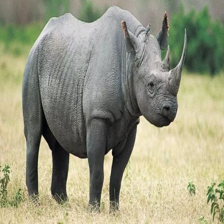

In [59]:
# read img (2 method: PIL/Tensorflow load img)
# 尺寸要跟當初source 差不多, Convert("RGB")怕灰階有問題
from PIL import Image
fs_hippo = glob.glob('drive/MyDrive/CNN/hippo/*')
fs_elephant = glob.glob('drive/MyDrive/CNN/elephant/*')
fs_rhino = glob.glob('drive/MyDrive/CNN/rhino/*')

Image.open(fs_hippo[6]).resize((224,224)).convert("RGB")
Image.open(fs_elephant[6]).resize((224,224)).convert("RGB")
Image.open(fs_rhino[6]).resize((224,224)).convert("RGB")

In [60]:
# stole model : keras application('https://keras.io/api/applications/')
# download and check the image size(69KB * 25000/ 1000 =~ 1G 耗RAM 要小心)
import pandas as pd
hippo = glob.glob('drive/MyDrive/CNN/hippo/*')
elephant = glob.glob('drive/MyDrive/CNN/elephant/*')
rhino = glob.glob('drive/MyDrive/CNN/rhino/*')

datas = pd.DataFrame({
    'path': hippo + elephant + rhino,
    'ans': [0] * len(hippo) + [1]* len(elephant) + [2] * len(rhino)

})
datas

,path,ans
0,drive/MyDrive/CNN/hippo/0.jpg,0
1,drive/MyDrive/CNN/hippo/1.jpg,0
2,drive/MyDrive/CNN/hippo/2.jpg,0
3,drive/MyDrive/CNN/hippo/3.jpg,0
4,drive/MyDrive/CNN/hippo/4.jpg,0
...,...,...
1208,drive/MyDrive/CNN/rhino/407.jpg,2
1209,drive/MyDrive/CNN/rhino/415.jpg,2
1210,drive/MyDrive/CNN/rhino/419.jpg,2
1211,drive/MyDrive/CNN/rhino/421.jpg,2


tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [61]:
# Create model: Kearas Application VGG16 : stole Weight
# 下游任務BERT（Bidirectional Encoder Representations from Transformers）

from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [62]:
# weak classification: 前面分的好(CNN 參數用的好)後面MLP Dense 參數就可少 128之類的
# Dense(2,activation = 'softmax')(1,activation = 'sigmoid')
# Trainable params: 可作梯度下降 , non-trainable: Freeze , trainable(只跑MLP)

# Total params: 17,926,338
# Trainable params: 3,211,650
# Non-trainable params: 14,714,688) original parameter
 
# new normalization: 2048 = 512 mu + 512 sigma +  512 new mu + 512 new sigma
# (Ori mu and sigma)1024 :non-trainable (New nu and sigma) 1024: trainable to find optimized loss

from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
vgg_layers = vgg.layers
for l in vgg_layers:
  l.trainable = False

clf_layers = [
              BatchNormalization(),
              GlobalAveragePooling2D(),
              Dense(3, activation = 'softmax')
]
model =  Sequential(vgg_layers + clf_layers)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [63]:
# Sparse 就不用自己做one-hot
# VVG16 非tensorflow 所以不用/255 ,因為VVG16是 caffe (follow original source)已作處理
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(), 
       optimizer="adam",
       metrics=["accuracy"])

In [64]:
# demo pre (preprocessing need to follow original source preprocessing)
import numpy as np
from tensorflow.keras.applications.vgg16 import preprocess_input
img = Image.open(fs[30]).resize((224, 224)).convert("RGB")
img_np = np.array(img)
preprocess_input(img_np)

array([[[ 1.3206100e+02,  1.1622100e+02,  1.0432000e+02],
        [ 1.3606100e+02,  1.2022100e+02,  1.0832000e+02],
        [ 1.3306100e+02,  1.1722100e+02,  1.0532000e+02],
        ...,
        [-6.2939003e+01, -5.7778999e+01, -4.0680000e+01],
        [-9.2939003e+01, -8.3778999e+01, -8.2680000e+01],
        [-9.4939003e+01, -8.2778999e+01, -9.4680000e+01]],

       [[ 1.3206100e+02,  1.1622100e+02,  1.0432000e+02],
        [ 1.3606100e+02,  1.2022100e+02,  1.0832000e+02],
        [ 1.3306100e+02,  1.1722100e+02,  1.0532000e+02],
        ...,
        [-6.8939003e+01, -6.6778999e+01, -5.3680000e+01],
        [-9.0939003e+01, -8.2778999e+01, -8.5680000e+01],
        [-8.9939003e+01, -7.9778999e+01, -9.3680000e+01]],

       [[ 1.3206100e+02,  1.1622100e+02,  1.0432000e+02],
        [ 1.3606100e+02,  1.2022100e+02,  1.0832000e+02],
        [ 1.3306100e+02,  1.1722100e+02,  1.0532000e+02],
        ...,
        [-8.3939003e+01, -8.4778999e+01, -7.7680000e+01],
        [-8.9939003e+01, -8.5

In [65]:
# example
# numpy.ranint exclusive, randomint inclusive
# 還沒讀圖不能直接使用fit (fit generator or / per batch validation (train on batch))
# 給群資料 回batch (多少張圖片gradiant descent)
# def get_data(x, y, batch = 20):

x, y = np.array(datas['path']), np.array(datas['ans'])

def get_data(x, y, batch = 20):
  idx = np.random.randint(0, len(x), size=batch)
  y_batch = y[idx]
  x_batch, x_batch_ori = [],[]
  for p in x[idx]:
    img = Image.open(p).resize((224, 224)).convert("RGB")
    img_np = np.array(img)
    img_np_pre = preprocess_input(img_np)
    x_batch.append(img_np_pre)
    x_batch_ori.append(img_np)
  return (np.array(x_batch), np.array(y_batch), np.array(x_batch_ori))
x_batch, y_batch, x_batch_ori = get_data(x, y)
print(x_batch.shape)
print(y_batch.shape)
print(x_batch_ori.shape)

(20, 224, 224, 3)
(20,)
(20, 224, 224, 3)


In [66]:
# train_on_batch 單次梯度更新 test_on_batch 在一批樣本上測試模型
for i in range(100):
  print('-'*10, i, '-'*10)
  x_batch, y_batch, x_batch_ori = get_data(x, y)
  result = model.train_on_batch(x_batch, y_batch)
  print('[Train]:',result)
  x_batch, y_batch, x_batch_ori = get_data(x, y)
  result = model.test_on_batch(x_batch, y_batch)
  print('[Validate]:',result)



---------- 0 ----------
[Train]: [1.1167742013931274, 0.3499999940395355]
[Validate]: [4.073561191558838, 0.25]
---------- 1 ----------
[Train]: [1.2518678903579712, 0.10000000149011612]
[Validate]: [2.4170100688934326, 0.20000000298023224]
---------- 2 ----------
[Train]: [1.0591061115264893, 0.44999998807907104]
[Validate]: [1.6685949563980103, 0.3499999940395355]
---------- 3 ----------
[Train]: [1.057700753211975, 0.5]
[Validate]: [1.651604413986206, 0.4000000059604645]
---------- 4 ----------
[Train]: [1.182411789894104, 0.20000000298023224]
[Validate]: [2.063166618347168, 0.25]
---------- 5 ----------
[Train]: [1.0542399883270264, 0.44999998807907104]
[Validate]: [1.6049991846084595, 0.25]
---------- 6 ----------
[Train]: [1.128463864326477, 0.20000000298023224]
[Validate]: [1.0658860206604004, 0.5]
---------- 7 ----------
[Train]: [1.018649935722351, 0.550000011920929]
[Validate]: [1.164387822151184, 0.44999998807907104]
---------- 8 ----------
[Train]: [0.8638470768928528, 0.69

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[Train]: [0.8689377903938293, 0.550000011920929]
[Validate]: [0.8634247779846191, 0.550000011920929]
---------- 21 ----------
[Train]: [0.8109091520309448, 0.699999988079071]
[Validate]: [0.5590340495109558, 0.800000011920929]
---------- 22 ----------
[Train]: [0.9374486207962036, 0.6000000238418579]
[Validate]: [0.8420540690422058, 0.6000000238418579]
---------- 23 ----------
[Train]: [0.790235161781311, 0.75]
[Validate]: [0.7104268670082092, 0.8500000238418579]
---------- 24 ----------
[Train]: [0.7795378565788269, 0.699999988079071]
[Validate]: [0.6086104512214661, 0.6000000238418579]
---------- 25 ----------
[Train]: [0.7090238332748413, 0.75]
[Validate]: [0.6747267842292786, 0.6499999761581421]
---------- 26 ----------
[Train]: [0.6651716232299805, 0.699999988079071]
[Validate]: [0.5112951397895813, 0.8999999761581421]
---------- 27 ----------
[Train]: [0.7550459504127502, 0.800000011920929]
[Validate]: [0.7237738370895386, 0.6499999761581421]
---------- 28 ----------
[Train]: [0.

In [67]:
model.predict(x_batch)

array([[0.07371264, 0.15837692, 0.7679104 ],
       [0.13129641, 0.16606344, 0.7026401 ],
       [0.13247997, 0.10419794, 0.76332206],
       [0.03966554, 0.907549  , 0.05278546],
       [0.9796936 , 0.0112025 , 0.00910385],
       [0.03650089, 0.91473705, 0.04876208],
       [0.7906725 , 0.13448223, 0.07484526],
       [0.72757673, 0.2096335 , 0.0627898 ],
       [0.08096533, 0.50972587, 0.40930882],
       [0.02223856, 0.9123865 , 0.06537498],
       [0.03449306, 0.9574338 , 0.00807308],
       [0.95648   , 0.02860049, 0.01491945],
       [0.6832417 , 0.19118355, 0.1255748 ],
       [0.01844426, 0.9368217 , 0.04473405],
       [0.06813344, 0.9185318 , 0.01333483],
       [0.24531004, 0.6187544 , 0.13593552],
       [0.43547156, 0.00787186, 0.5566566 ],
       [0.04971547, 0.81602633, 0.13425823],
       [0.2980131 , 0.44936913, 0.2526178 ],
       [0.09311893, 0.8367449 , 0.07013617]], dtype=float32)

In [68]:
# evaluate
x_batch, y_batch, x_batch_ori = get_data(x, y, 2000)
model.evaluate(x_batch, y_batch)

63/63 [==============================] - 9s 137ms/step - loss: 0.3625 - accuracy: 0.8790


[0.36250606179237366, 0.8790000081062317]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


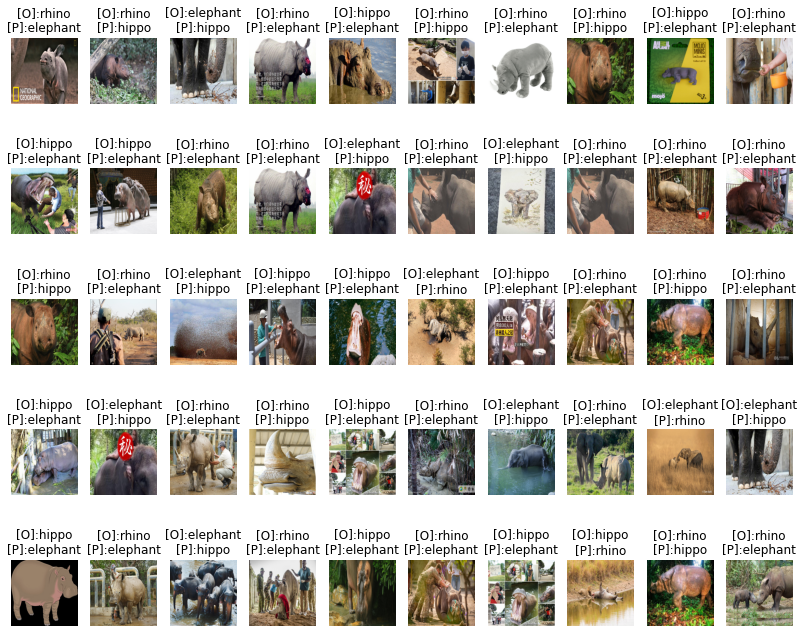

In [69]:

import numpy as np
import matplotlib.pyplot as plt

pre = model.predict_classes(x_batch)
trans = ["hippo", "elephant", "rhino"]
idx = np.nonzero(pre != y_batch)[0][:50]
false_img = x_batch_ori[idx]
false_pre = pre[idx]
false_label = y_batch[idx]
plt.figure(figsize=(14, 14))
width = 10
height = len(idx) // width + 1
for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[false_label[i]], trans[false_pre[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(false_img[i])

url:https://image.shutterstock.com/image-photo/yawning-common-hippopotamus-water-sunset-600w-1186562245.jpg
hippo 的機率: 0.74402946
elephant 的機率: 0.052453082
rhino 的機率: 0.20351736
答案: hippo


/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


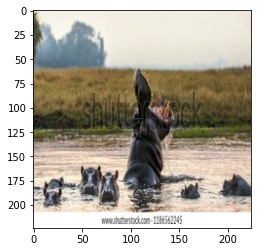

In [76]:

# Pillow
import requests
from PIL import Image
# RGB, RGBA, L(gray)
url = input("url:")
headers = {
  "user-agent":"user-agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.90 Safari/537.36"  
}
response = requests.get(url, headers=headers, stream=True, verify=False)
img = Image.open(response.raw).resize((224, 224)).convert("RGB")
img_np = np.array(img)
img_np_r = preprocess_input(img_np.reshape(1, 224, 224, 3))
proba = model.predict(img_np_r)[0]
for i, p in enumerate(proba):
    print(trans[i], "的機率:", p)

ans = model.predict_classes(img_np_r)[0]
print("答案:", trans[ans])
plt.imshow(img_np)

# rhino
# https://cdn.cnn.com/cnnnext/dam/assets/210312142740-09-rhino-airlift-south-africa-exlarge-169.jpg
# https://cdn.cnn.com/cnnnext/dam/assets/210312020634-07-rhino-airlift-upside-down-restricted-exlarge-169.jpg

#  elephant
# https://dynaimage.cdn.cnn.com/cnn/q_auto,w_634,c_fill,g_auto,h_357,ar_16:9/http%3A%2F%2Fcdn.cnn.com%2Fcnnnext%2Fdam%2Fassets%2F201129194805-01-cher-pakistan-elephant-intl-hnk.jpg
# https://image.shutterstock.com/image-photo/background-elephant-600w-133689230.jpg
# https://image.shutterstock.com/image-photo/elephant-mom-takes-care-baby-600w-1567623142.jpg

# hippo
# https://image.shutterstock.com/image-photo/hippopotamus-hippos-liwonde-np-malawi-600w-1112978063.jpg
# https://image.shutterstock.com/image-photo/yawning-common-hippopotamus-water-sunset-600w-1186562245.jpg
